In [1]:
# imports from the pyfoomb package
import pyfoomb
print(f'Current package version of {pyfoomb.__name__}: {pyfoomb.__version__}')

from pyfoomb import BioprocessModel
from pyfoomb import ObservationFunction
from pyfoomb import Caretaker
from pyfoomb import Visualization
from pyfoomb import Measurement
from pyfoomb import ParameterMapper
from pyfoomb.utils import Helpers

C:\Users\hemmerich\AppData\Local\Continuum\miniconda3\envs\pyfoomb-dev\lib\site-packages\assimulo\solvers\odepack.py:701: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  N.array([[0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.],  # 5th order
Could not find GLIMDA.


Current package version of pyfoomb: 2.17.7


In [2]:
from matplotlib import pyplot
import numpy

# Set seed of random number generator for reproducibility
numpy.random.seed(123)

# Parallelized parameter estimation

This notebook demonstrates the basic use and evaluation of two `Caretaker` methods that parallelize the parameter estimation process with global optimization algorithms. This functionality is provided by the super cool `pygmo` package, see https://esa.github.io/pygmo2/.

### Some helper functions for this notebook

In [3]:
# Creates a noisy dataset, based on a forward simulation
def noisy_samples(simulations, samples=5, rel_err=0.05, abs_err=0.05, repetitions=3, with_errors=True):
    artifical_data = []
    
    # get joint time points
    t_all = Helpers.get_unique_timepoints(simulations)

    # iterate over simulations
    for simulation in simulations:
        
        _name = simulation.name
        _replicate_id = simulation.replicate_id
        _t_samples = numpy.random.choice(simulation.timepoints, size=samples, replace=False)
        _sample_idxs = numpy.in1d(simulation.timepoints, _t_samples)
        _timepoints = simulation.timepoints[_sample_idxs]
        _values = simulation.values[_sample_idxs]
        
        # generate random samples
        _rnd_values = [
            numpy.random.normal(loc=_values, scale=abs(_values*rel_err+abs_err)) 
            for _ in range(repetitions)
        ]
        
        # create new Measurement object
        _measurement = Measurement(
            name=_name, 
            replicate_id=_replicate_id,
            timepoints=_timepoints, 
            values=numpy.mean(_rnd_values, axis=0),
            errors=numpy.std(_rnd_values, ddof=1, axis=0) if with_errors else None,
        )
        artifical_data.append(_measurement)
        
    return artifical_data


def make_experiment(caretaker:Caretaker, tfinal:float, samples:int=3, show:bool=True):
    
    simulation = caretaker.simulate(t=tfinal)
    data = noisy_samples(caretaker.simulate(t=numpy.arange(tfinal*4)/4), samples=samples)
    if show:
        _ncols = len(set([_item.name for _item in simulation]))
        _ = Visualization.show_kinetic_data(simulation, ncols=_ncols)
        _ncols = len(set([_item.name for _item in data]))
        _ = Visualization.show_kinetic_data(data, ncols=_ncols)

    return data, simulation

# Example 1: A bioprocess model


First, the bioprocess model is defined. This model is also used to generate some noisy artifical data to demonstrate the parameter estimation process.

In [4]:
# Defines the model class
class GrowthCoupledProduction(BioprocessModel):
        
    def specific_growth_rate_mu(self, t, y):
        P, S, X = y
        kS = self.model_parameters['kS']
        mu_max = self.model_parameters['mu_max']
        mu = mu_max * S / (kS + S)
        return mu
    
    def specific_production_rate_qP(self, t, y):
        P, S, X = y
        YPX = self.model_parameters['YPX']
        mu = self.specific_growth_rate_mu(t, y)
        qP = YPX * mu
        return qP
    
    def specific_substrate_consumption_rate_qS(self, t, y):
        P, S, X = y
        YXS = self.model_parameters['YXS']
        YPS = self.model_parameters['YPS']
        mu = self.specific_growth_rate_mu(t, y)
        qP = self.specific_production_rate_qP(t, y)
        qS = 1/YXS * mu + 1/YPS * qP
        return qS
    
    def rhs(self, t, y):
        
        # Unpacks the state vector. The states are alphabetically ordered.
        P, S, X = y

        # Calculate specific rates
        mu = self.specific_growth_rate_mu(t, y)
        qP = self.specific_production_rate_qP(t, y)
        qS = self.specific_substrate_consumption_rate_qS(t, y)

        # Calculate state derivatives
        dXdt = mu * X
        dSdt = -qS * X
        dPdt = qP * X
        
        return [dPdt, dSdt, dXdt]

    
model_parameters = {
    'kS' : 0.05,
    'mu_max' : 0.4,
    'YXS' : 0.6,
    'YPS' : 0.4,
    'YPX' : 0.2,
}     

initial_values = {
    'S0' : 20.0,
    'X0' : 0.01,
    'P0' : 0.0,
}

# Instantiates are caretaker with two replicate_ids
caretaker = Caretaker(
    bioprocess_model_class=GrowthCoupledProduction, 
    model_parameters=model_parameters, 
    initial_values=initial_values,
    replicate_ids=['1st', '2nd'],
)

In [5]:
# Define mapping to make the initial values local parameters for the replicate_id
mappings = [
    ParameterMapper(replicate_id='1st', global_name='S0', value=20.0),
    ParameterMapper(replicate_id='1st', global_name='X0', value=0.01),
    ParameterMapper(replicate_id='1st', global_name='P0', value=0.0),
    ParameterMapper(replicate_id='2nd', global_name='S0', value=10.0),
    ParameterMapper(replicate_id='2nd', global_name='X0', value=0.01),
    ParameterMapper(replicate_id='2nd', global_name='P0', value=0.0),
]
caretaker.apply_mappings(mappings)

# Save for later comparison
_pars_for_comp = caretaker._get_all_parameters()

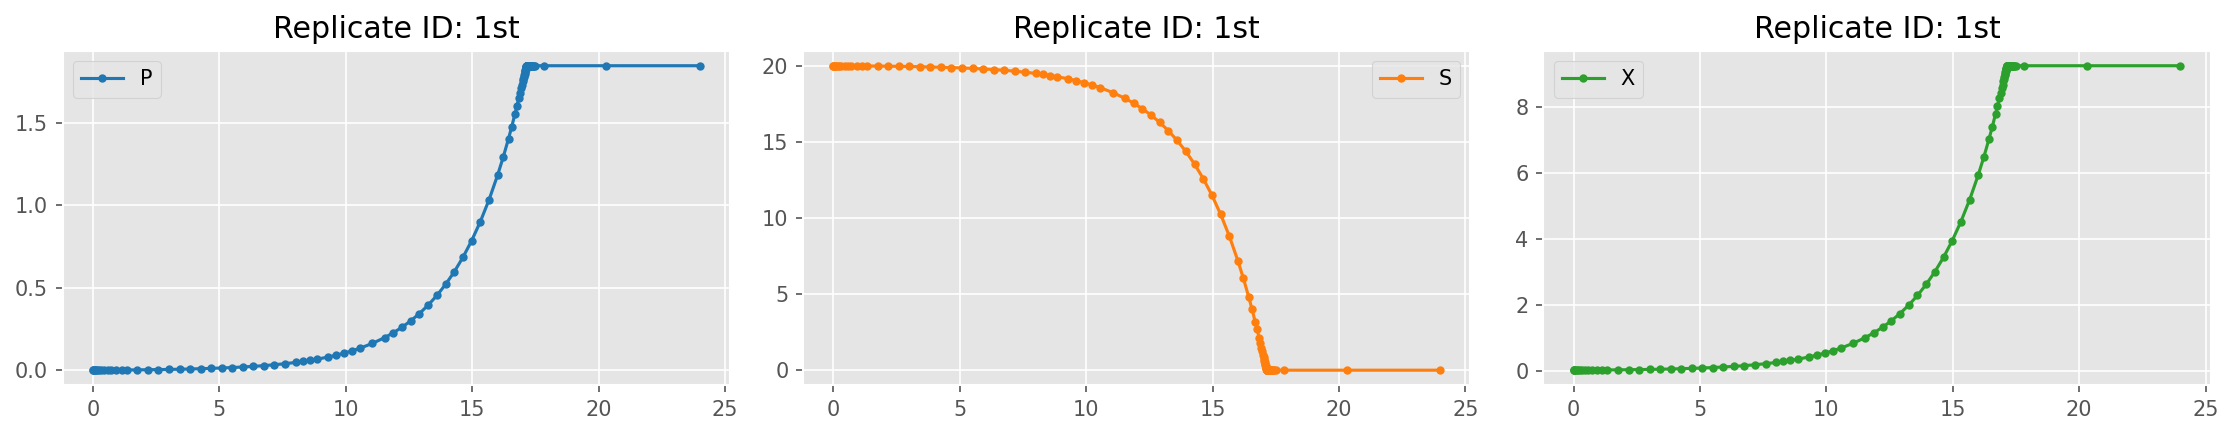

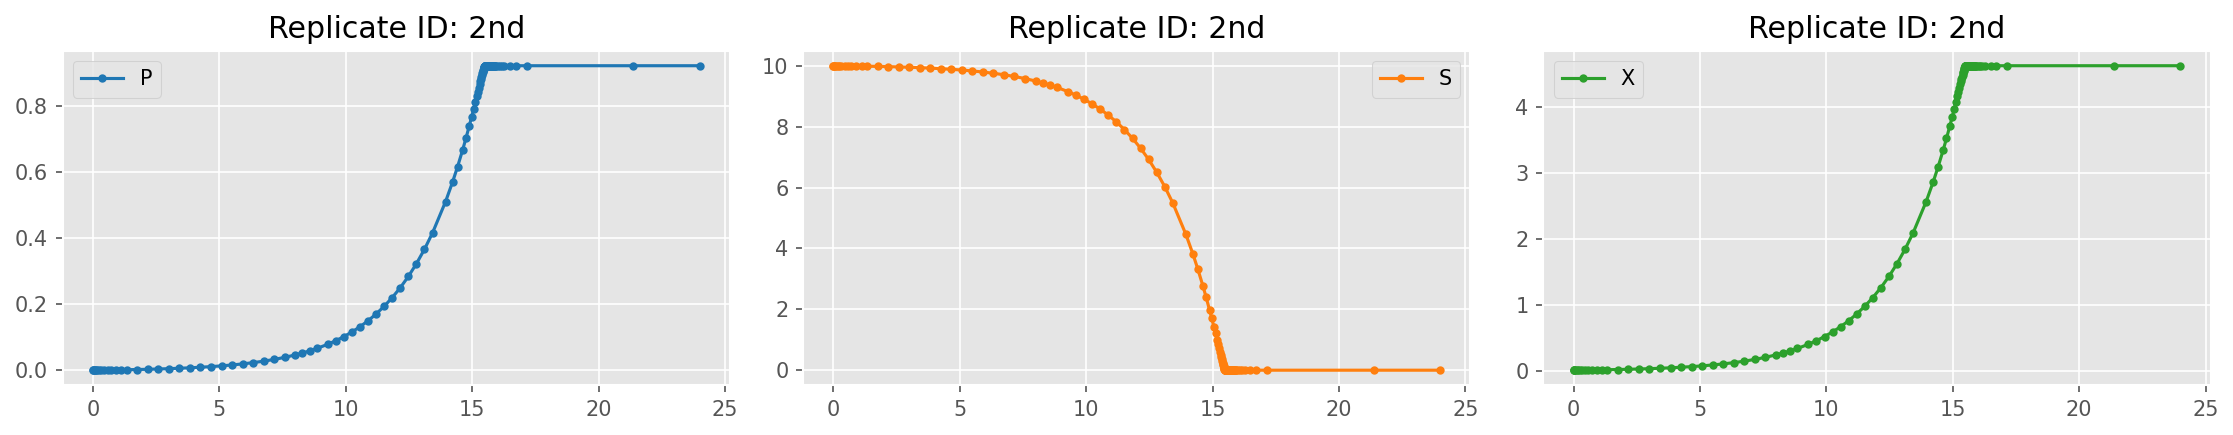

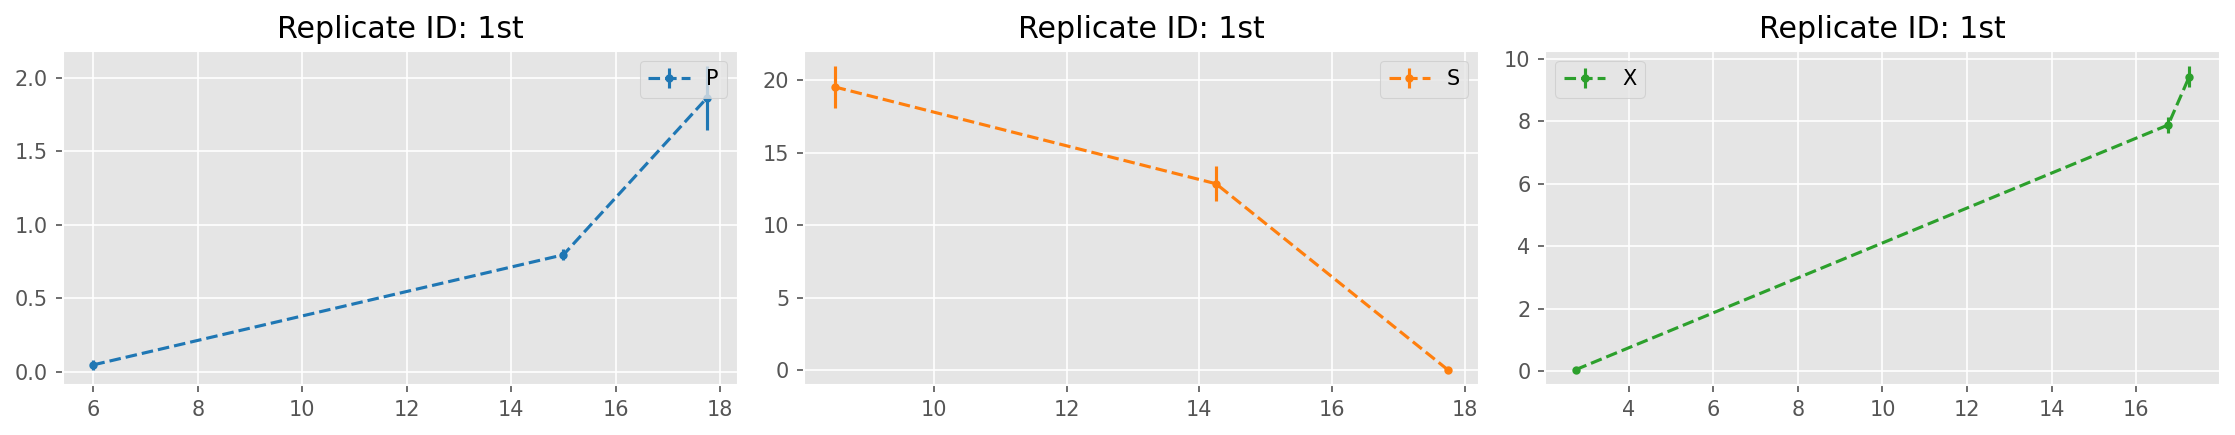

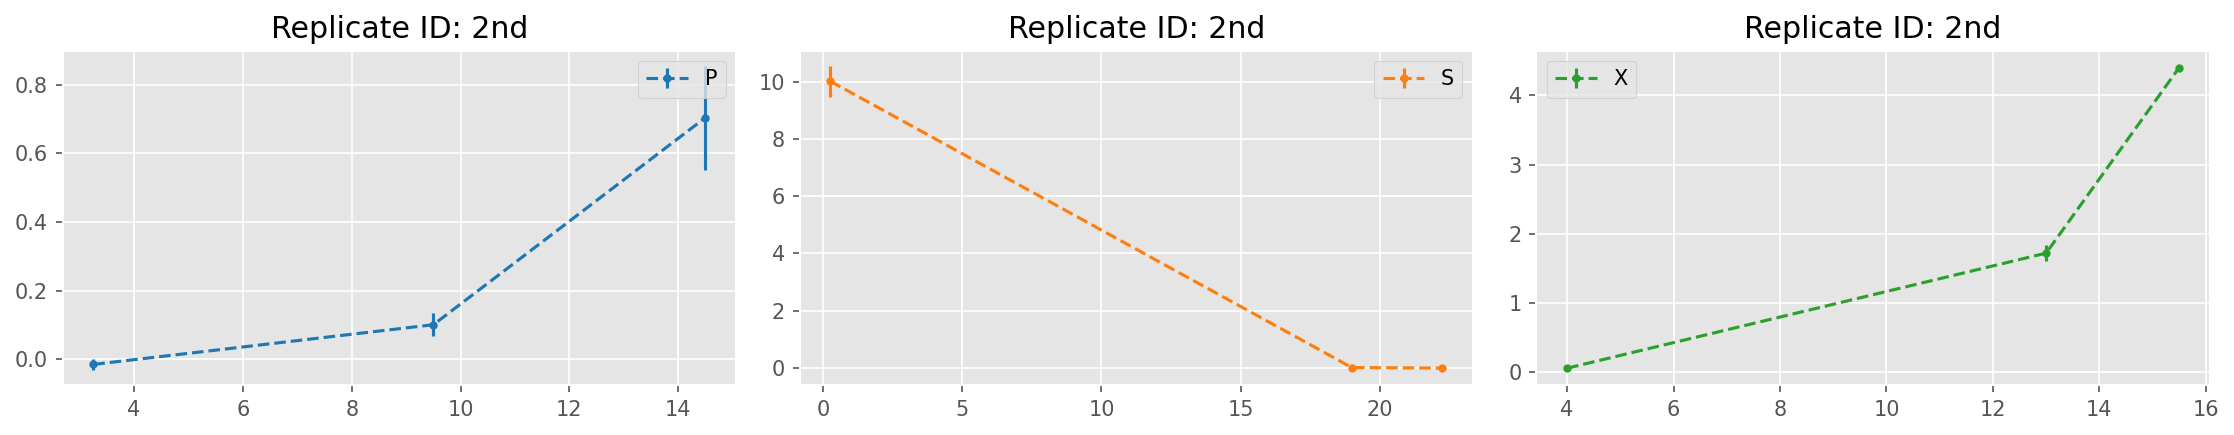

In [6]:
# Generates noisy artificial data from the simulation
data, simulation = make_experiment(caretaker, tfinal=24)

## Parameter estimation
As usual, the `unknowns` and corresponding `bounds` have to specified for the estimation job.

In [7]:
# Defines the unknowns to be estimated, as well as corresponding bounds
unknowns = [
    'kS', 
    'mu_max', 
    'YXS', 
    'YPS', 
    'YPX',
    'S0_1st',
    'S0_2nd'
]

bounds = [
    (0.01, 1),
    (0.1, 1),
    (0.1, 1),
    (0.1, 1),
    (0.1, 1),
    (17.5, 22.5),
    (8, 10),
]

### Method `estimate_parallel`

When using the `estimate_parallel()` method with its default setting, the DE1220 optimization algorithm of the `pygmo` package is used, and parallelizes over all available cpus. Five evolutions are run.

There are three main critera that determine how long a parameter estimation process will take:

1. Number of evolutions (argument `evolutions`, default: `5`)
2. Convergence, calculated from the best losses of all parallel jobs after each finished evolution (arguments `atol_islands` and `rtol_islands`, with `None` and `1e-6` as default values, respectively)
3. the maximum runtime in min (`max_runtime_min`, default: `None`)

In [8]:
# Calling the method with its default keyword arguments
estimates, est_info = caretaker.estimate_parallel(
    unknowns=unknowns,
    bounds=bounds,
    measurements=data, 
    report_level=3, # We set the report_level to see some output during the optimization process.
)

Creating archipelago with 12 islands. May take some time...


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   2 out of  12 | elapsed:    3.1s remaining:   15.8s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:    3.2s finished


Running 5 evolutions for all 12 islands of the archipelago...

-------------Finished evolution 1-------------
Current best loss: -7.5635378734906205
Average loss among the islands: 25.674544 +/- 32.183808 (125.352990 %)
-------------Finished evolution 2-------------
Current best loss: -24.542684838214303
Average loss among the islands: -9.714063 +/- 10.202782 (105.031037 %)
-------------Finished evolution 3-------------
Current best loss: -26.823676279664106
Average loss among the islands: -21.001146 +/- 5.071278 (24.147626 %)
-------------Finished evolution 4-------------
Current best loss: -27.664187071817107
Average loss among the islands: -25.385972 +/- 1.864748 (7.345586 %)
-------------Finished evolution 5-------------
Current best loss: -27.728969714128603
Average loss among the islands: -26.793198 +/- 0.718979 (2.683439 %)

Completed 5 evolution runs.

Estimated parameters:
kS: 0.16036016274852874
mu_max: 0.40192277403838517
S0_1st: 19.77326880800789
S0_2nd: 9.915887127070967
Y

Afterwards, we can visually inspect how the estimates fit with the data. Because we're working with artificial data, we can also compare to the trajectories resulting from the "true" parameter values.

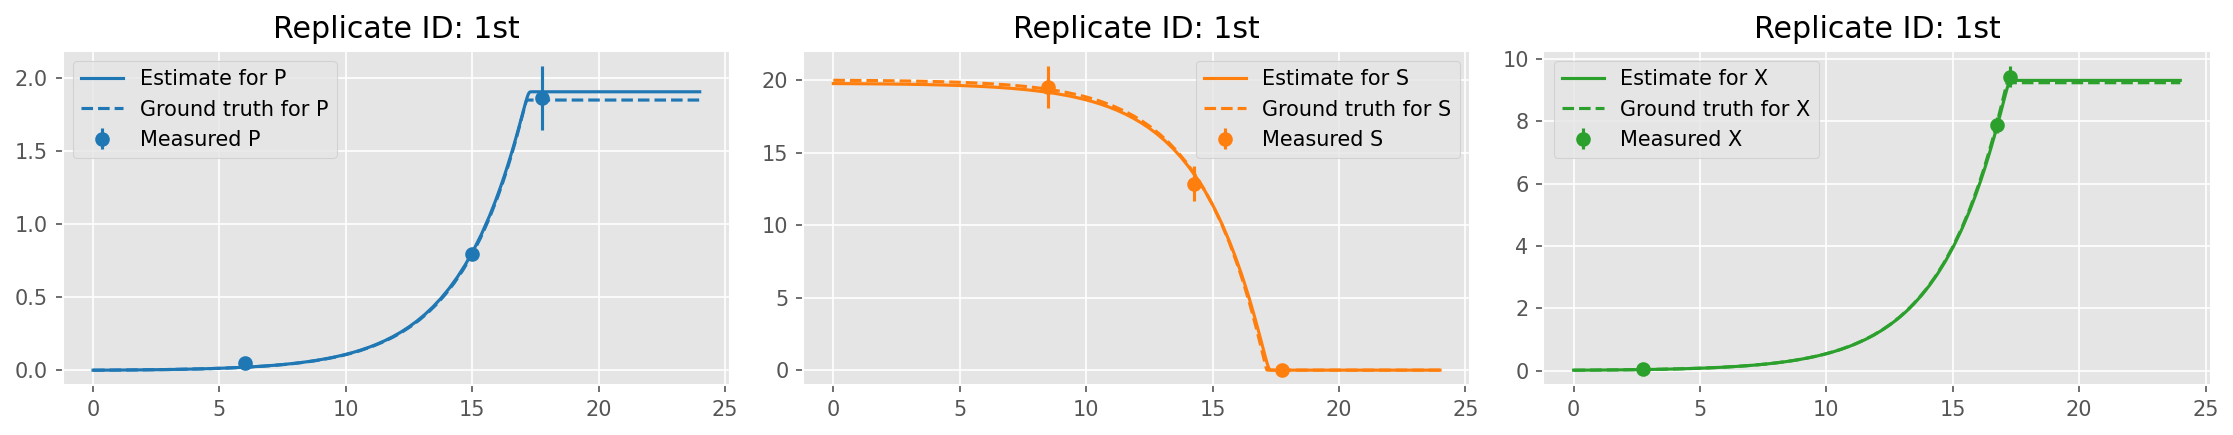

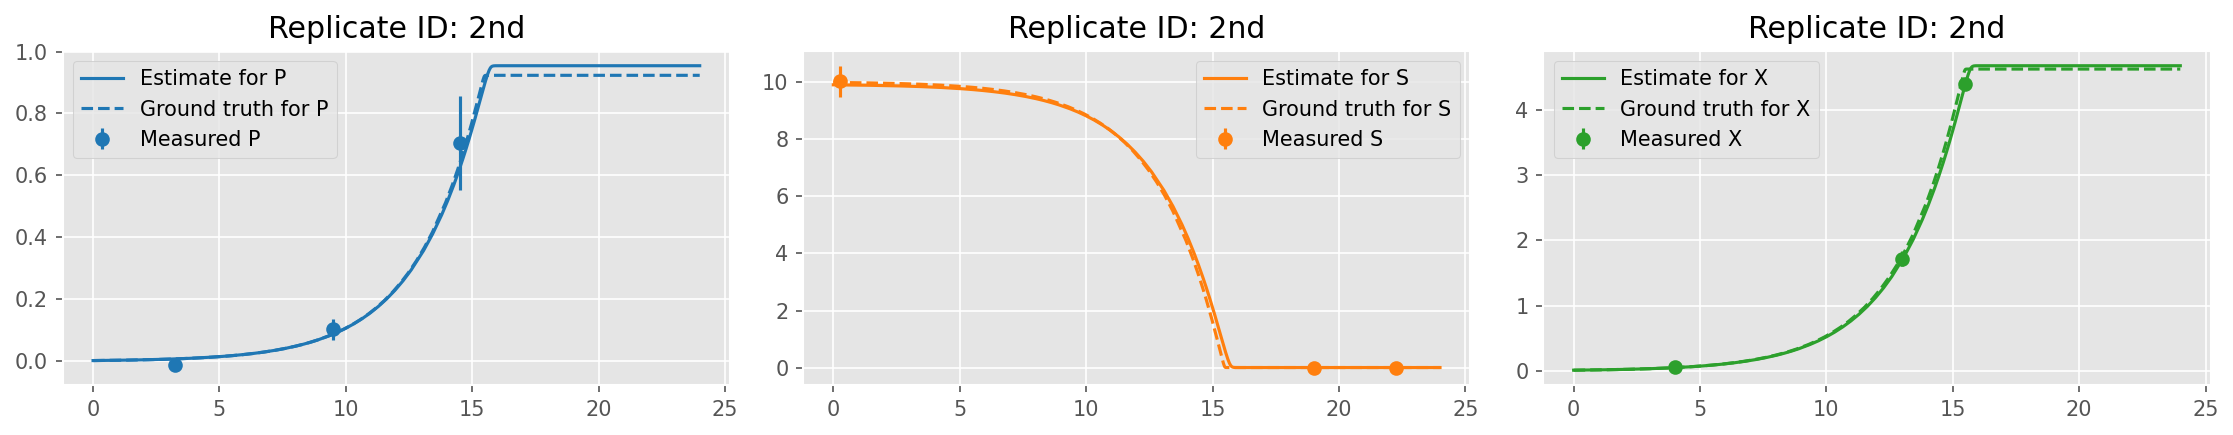

In [9]:
_ = Visualization.compare_estimates(parameters=estimates, measurements=data, caretaker=caretaker, truth=simulation)

### Method `estimate_parallel_continued()`

As the parallel estimation method is built on the functionalities of the `pygmo` package, we are able to __continue__ the estimation process. This is conveniently realized by the `Caretaker`'s method `estimate_parallel_continued()`, as seen below.
Afterwards, the estimates are again visually evaluated.

In [10]:
estimates, est_info = caretaker.estimate_parallel_continued(
    estimation_result=est_info,
    evolutions=25, # Run another 25 evolutions
    report_level=2, # Reduce verbosity
)

Running additional 25 evolutions for all 12 islands of the archipelago...

-------------Finished evolution 6-------------
Current best loss: -27.820176432783672
-------------Finished evolution 7-------------
Current best loss: -27.829983850400776
-------------Finished evolution 8-------------
Current best loss: -27.838558767328355
-------------Finished evolution 9-------------
Current best loss: -27.840363871131515
-------------Finished evolution 10-------------
Current best loss: -27.840412958218952
-------------Finished evolution 11-------------
Current best loss: -27.840472222137368
-------------Finished evolution 12-------------
Current best loss: -27.84047603990562
-------------Finished evolution 13-------------
Current best loss: -27.840493631801237
-------------Finished evolution 14-------------
Current best loss: -27.84052362680091
-------------Finished evolution 15-------------
Current best loss: -27.84052462951711
-------------Finished evolution 16-------------
Current best l

### Final evaluations of the model calibration process
1. Visual inspection of trajectories and comparison to measurement data
2. Approximation of parameter uncertainties, based on Fisher information matrix
3. Visualization of the development of the parameter estimation process
4. Comparison of estimated values to the "true" value, which were used for generation of the artificial data

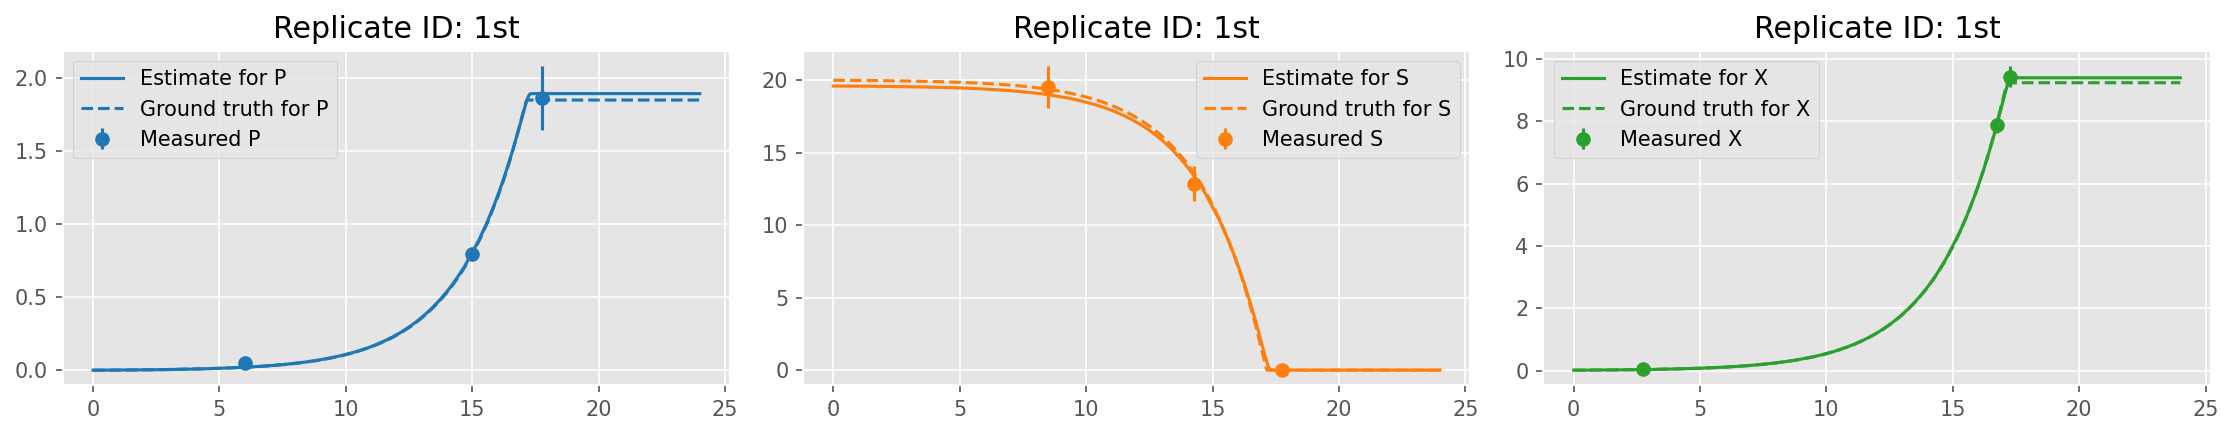

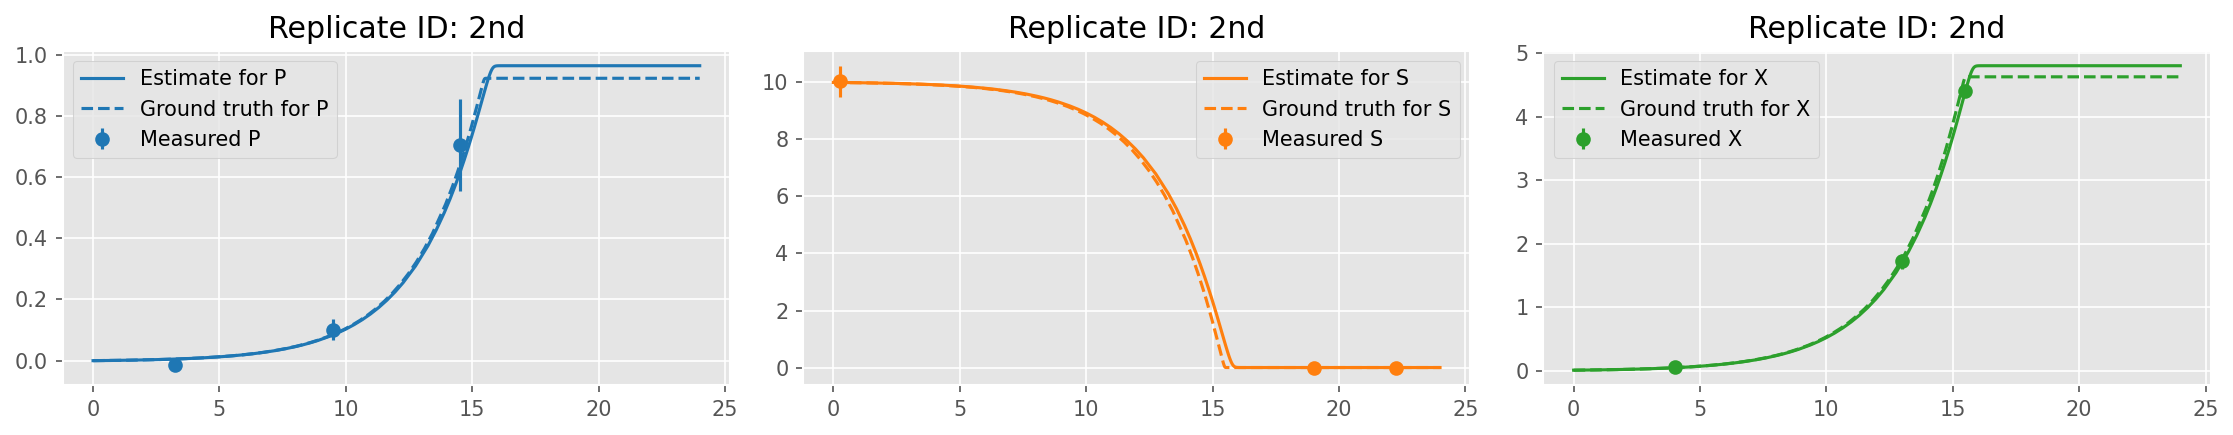

In [11]:
_ = Visualization.compare_estimates(parameters=estimates, measurements=data, caretaker=caretaker, truth=simulation)

Now we can estimate the parameter uncertainties based on the Fisher information matrix.

In [12]:
uncerts = caretaker.get_parameter_uncertainties(estimates, measurements=data, report_level=1)


Estimated parameters:
----------
kS: 1.97e-01 +/- 9.90e-02 (50.32 %)
mu_max: 4.04e-01 +/- 4.44e-03 (1.10 %)
S0_1st: 1.96e+01 +/- 1.17e+00 (5.96 %)
S0_2nd: 1.00e+01 +/- 5.41e-01 (5.41 %)
YPS: 8.56e-01 +/- 1.44e+01 (1678.21 %)
YPX: 2.01e-01 +/- 1.03e-02 (5.10 %)
YXS: 5.40e-01 +/- 1.15e+00 (213.01 %)


The `est_info` variable, an instance of the `ParallelEstimationInfo` class, provides a convenience method to show the development of the estimation process retrospectively.

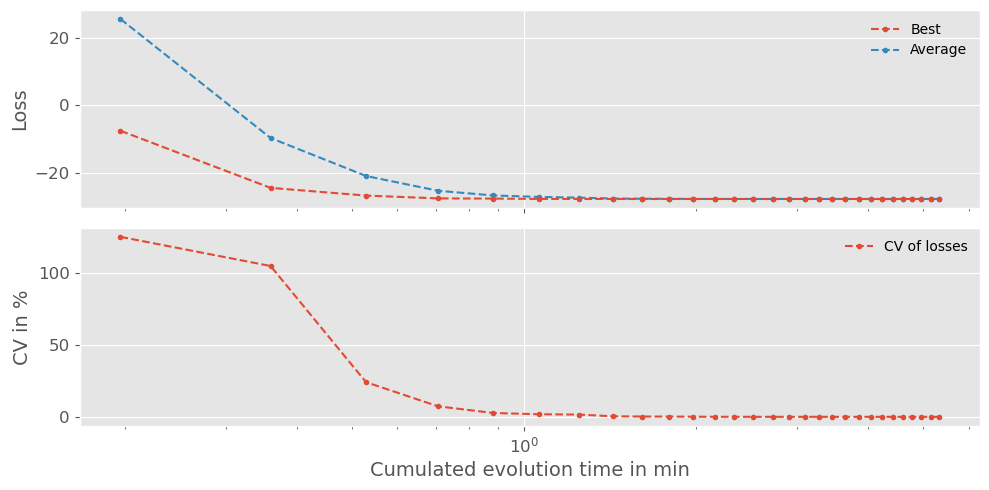

In [13]:
_ = est_info.plot_loss_trail()

Finally, we can compare the estimated values to the "true" values, which were used to generated the artificial data.

<ipython-input-14-0b2493e8e4ec>:4: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_yscale('log', basey=2)


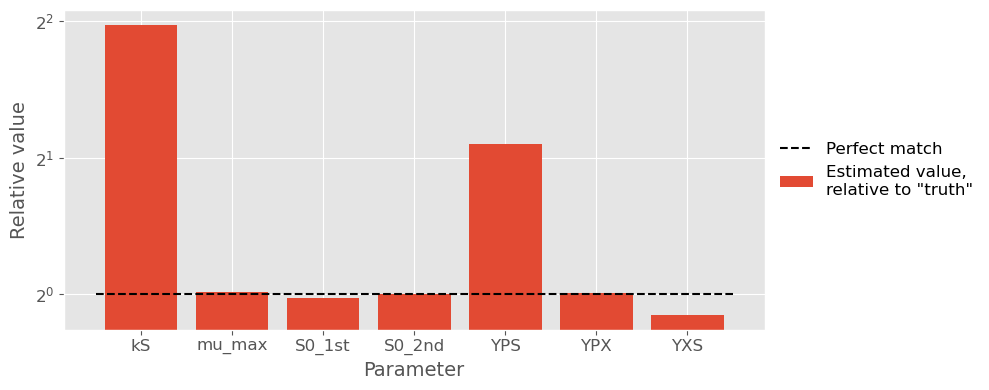

In [14]:
fig, ax = pyplot.subplots(dpi=100, figsize=(10, 4))
rel_estimates = {_p : estimates[_p]/_pars_for_comp[_p] for _p in estimates}
ax.bar(rel_estimates.keys(), rel_estimates.values(), label='Estimated value,\nrelative to "truth"')
ax.set_yscale('log', basey=2)
_x = numpy.arange(len(unknowns))
_x = [_x[0]-0.5, *_x, _x[-1]+0.5]
ax.plot(_x, [1]*len(_x), linestyle='--', zorder=2, color='black', label='Perfect match')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12, frameon=False)
ax.set_xlabel('Parameter', size=14)
ax.set_ylabel('Relative value', size=14)
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
fig.tight_layout()

# Example 2: Complex kinetics

In the following, the whole procedure is repeated for another example.

NOTE: This example will require a longer runtime because of its complexity

In [15]:
# Defines the model class
class ComplexKinetic(BioprocessModel):
    
    def rhs(self, t, y):
        # Unpacks the state vector. The states are alphabetically ordered.
        A, B, C, D, E = y
        
        # Unpacks the model parameters.
        kAB = self.model_parameters['kAB']
        kAD = self.model_parameters['kAD']
        kDA = self.model_parameters['kDA']
        kDB = self.model_parameters['kDB']
        kBD = self.model_parameters['kBD']
        kBC = self.model_parameters['kBC']
        kCB = self.model_parameters['kCB']
        kDE = self.model_parameters['kDE']
        kDC = self.model_parameters['kDC']

        # Defines the derivatives.
        dAdt = -kAB*A - kAD*A + kDA*D
        dBdt = kAB*A - kBC*B + kCB*C + kDB*D - kBD*B
        dCdt = kBC*B - kCB*C + kDC*D
        dDdt = kAD*A - kDA*D - kDE*D + kBD*B - kDB*D - kDC*D
        dEdt = kDE*D
        
        # Returns the derivative as list (or numpy array).
        # The order corresponds to the state vector.
        return [dAdt, dBdt, dCdt, dDdt, dEdt]
    
    
# Defines a dictionary for the initial values.
# The keys corresponds to the model states, extended by a 0 (zero).
initial_values = {
    'A0' : 100.0,
    'B0' : 0.0,
    'C0' : 0.0,
    'D0' : 5.0,
    'E0' : 0.0,
}

# Defines a dictionary for the model parameters
# The keys match those variable names used in the model class
model_parameters = {
    'kAB' : 0.2,
    'kAD' : 1e-4,
    'kDA' : 1.5,
    'kDB' : 0.05,
    'kBD' : 5.9,
    'kCB' : 0.1,
    'kBC' : 10.2,
    'kDE' : 2.5,
    'kDC' : 10.0,
}

In [16]:
replicate_ids = ['1st', '2nd']

caretaker = Caretaker(
    bioprocess_model_class=ComplexKinetic, 
    model_parameters=model_parameters, 
    initial_values=initial_values,
    replicate_ids=replicate_ids
)

# Define mapping to make the initial values local parameters with different values for the replicate_ids. 
mappings = [
    ParameterMapper(
        replicate_id=_replicate_id, 
        global_name=_iv, 
        value=initial_values[_iv]*numpy.random.uniform(low=0.5, high=2.0),
    )
    for _replicate_id in replicate_ids
    for _iv in initial_values.keys()
]
caretaker.apply_mappings(mappings)

# Save for later comparison
_pars_for_comp = caretaker._get_all_parameters()

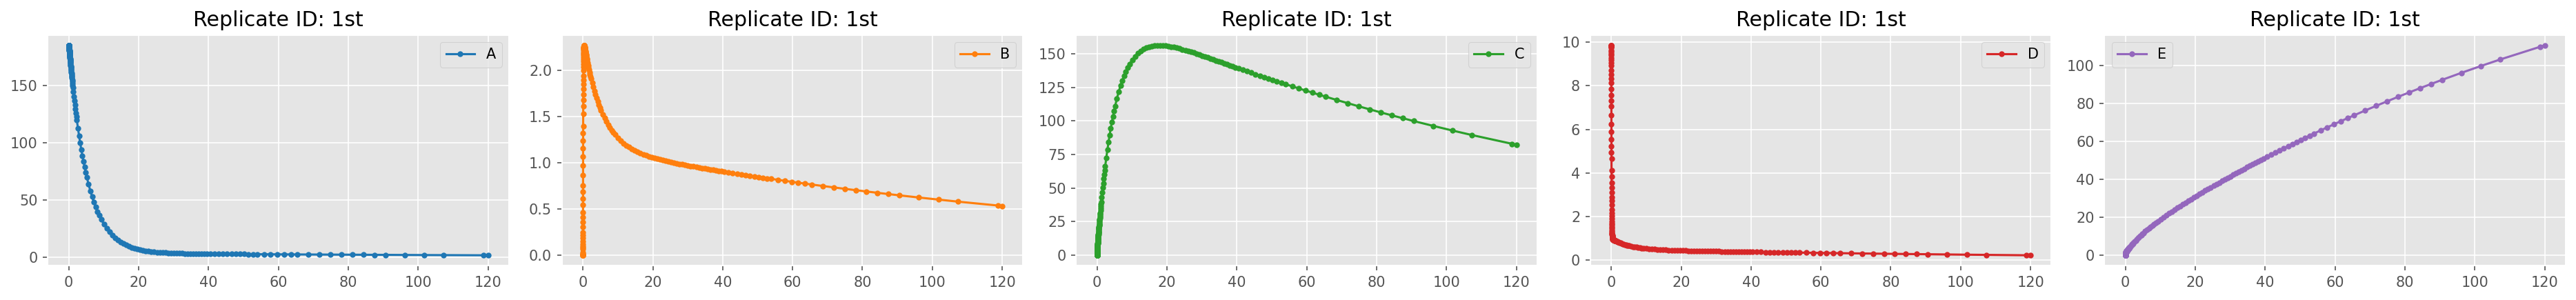

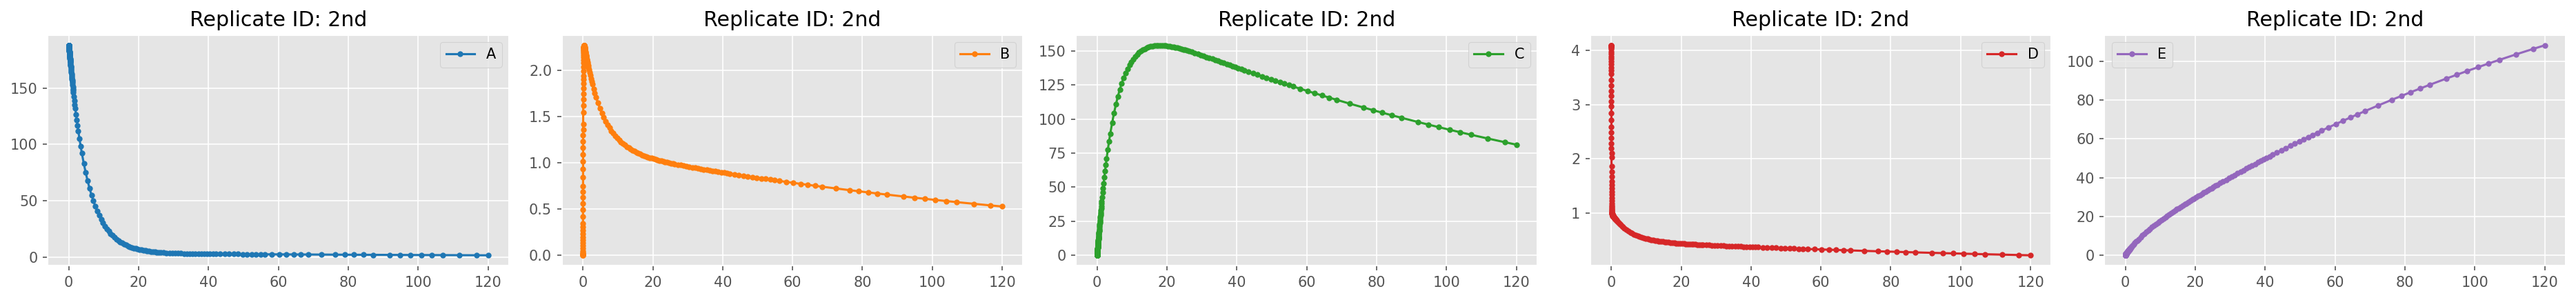

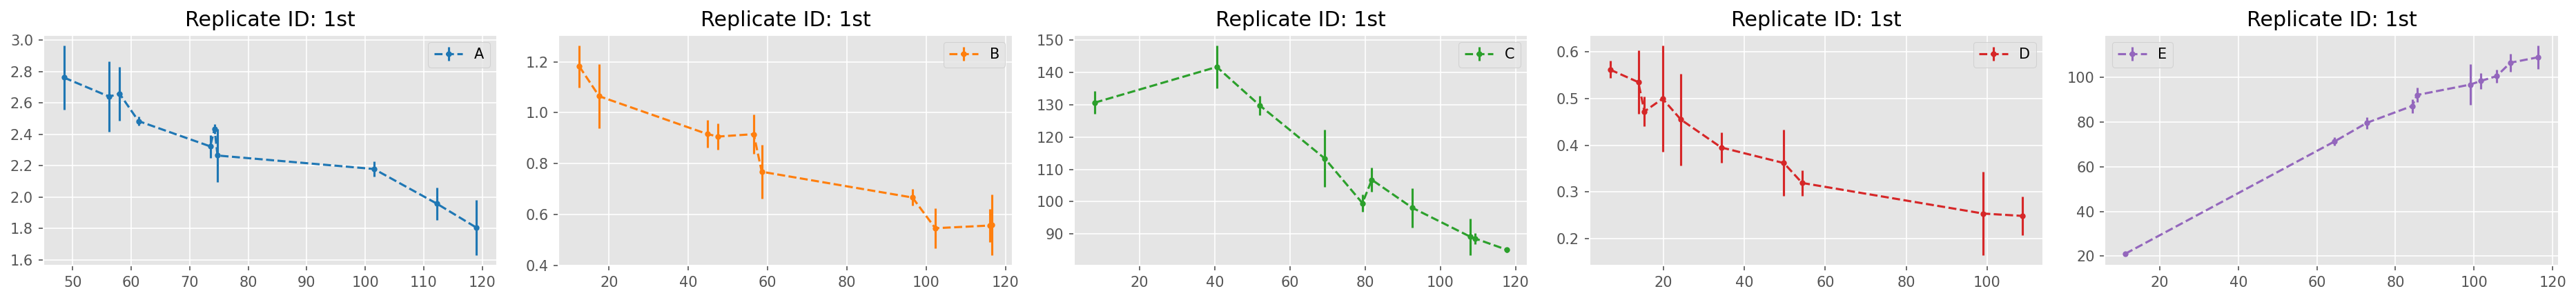

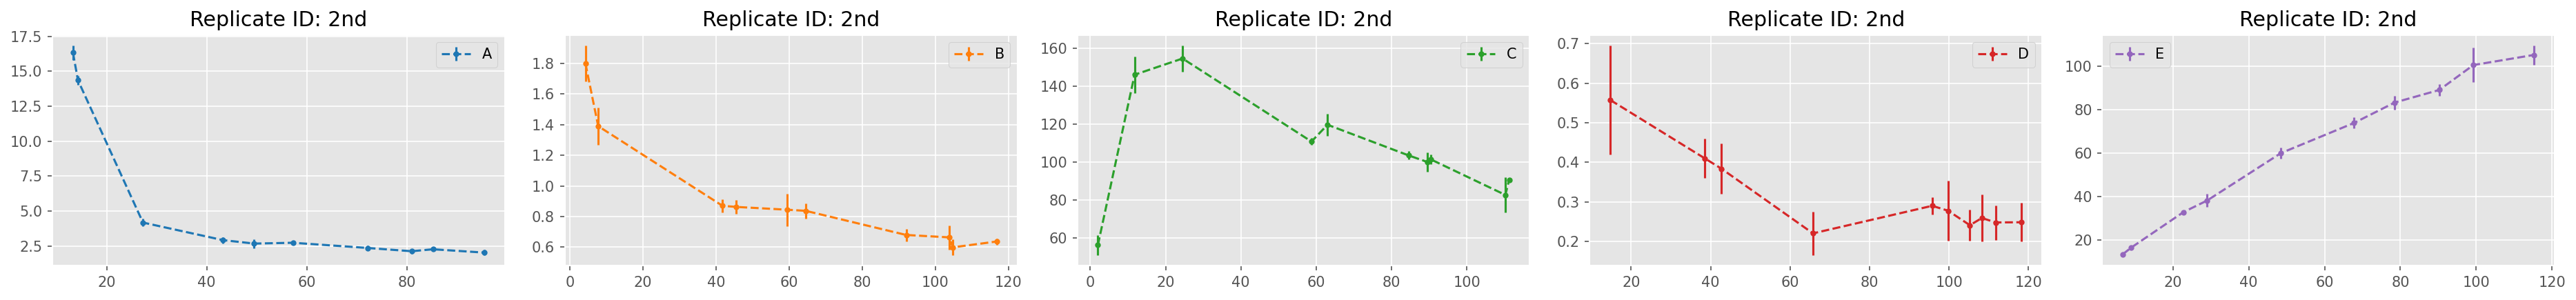

In [17]:
data, simulation = make_experiment(caretaker, tfinal=120, samples=10)

In [18]:
# Defines the unknowns to be estimated, as well as corresponding bounds
unknowns = ['kAB', 'kAD', 'kDA', 'kDB', 'kBD', 'kCB', 'kBC', 'kDE', 'kDC']
bounds = [(0.0, 100.0)]*len(unknowns)

In [19]:
estimates, est_info = caretaker.estimate_parallel(
    unknowns=unknowns,
    bounds=bounds,
    measurements=data, 
    report_level=3, # We set the report_level to see some output during the optimization process.
)

Creating archipelago with 12 islands. May take some time...


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   2 out of  12 | elapsed:    1.8s remaining:    9.6s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:    2.0s finished


Running 5 evolutions for all 12 islands of the archipelago...

-------------Finished evolution 1-------------
Current best loss: 13016.141565982798
Average loss among the islands: 15884.912131 +/- 3397.837516 (21.390345 %)
-------------Finished evolution 2-------------
Current best loss: 8524.435261294328
Average loss among the islands: 11699.074967 +/- 1446.780370 (12.366622 %)
-------------Finished evolution 3-------------
Current best loss: 2720.662218682176
Average loss among the islands: 6239.919550 +/- 2868.215783 (45.965589 %)
-------------Finished evolution 4-------------
Current best loss: 1514.636898729986
Average loss among the islands: 3270.018828 +/- 2126.449062 (65.028649 %)
-------------Finished evolution 5-------------
Current best loss: 1417.6402392123396
Average loss among the islands: 1976.184153 +/- 618.192058 (31.282108 %)

Completed 5 evolution runs.

Estimated parameters:
kAB: 2.573328893124479
kAD: 10.940431840225102
kBC: 61.97293510058705
kBD: 71.3166479905626


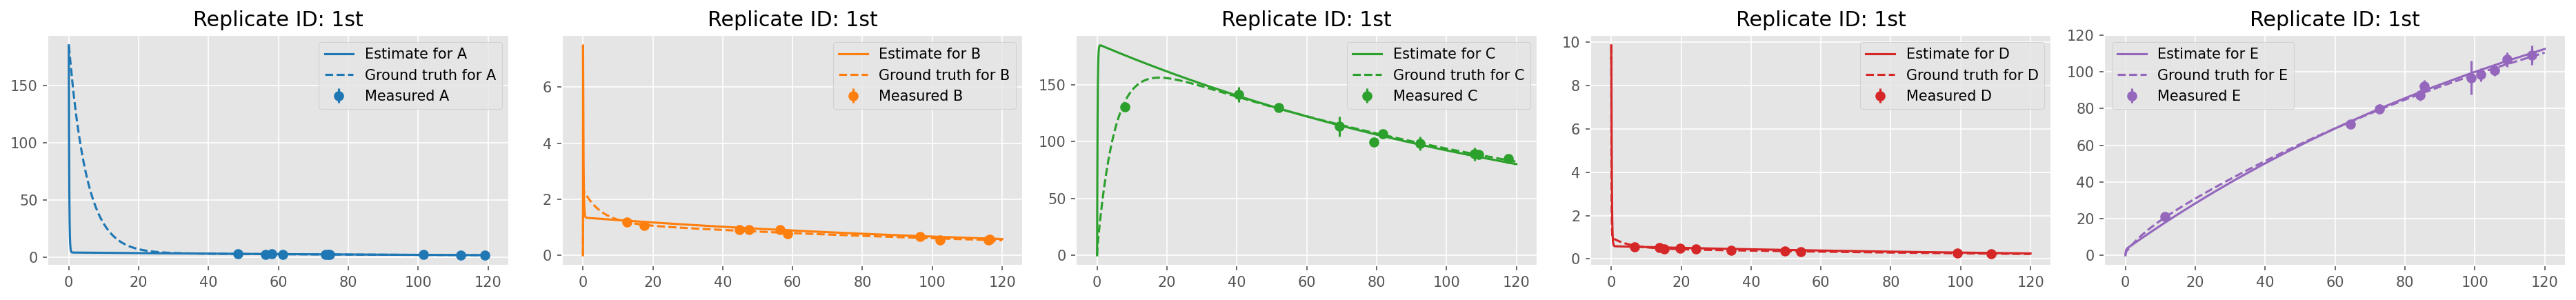

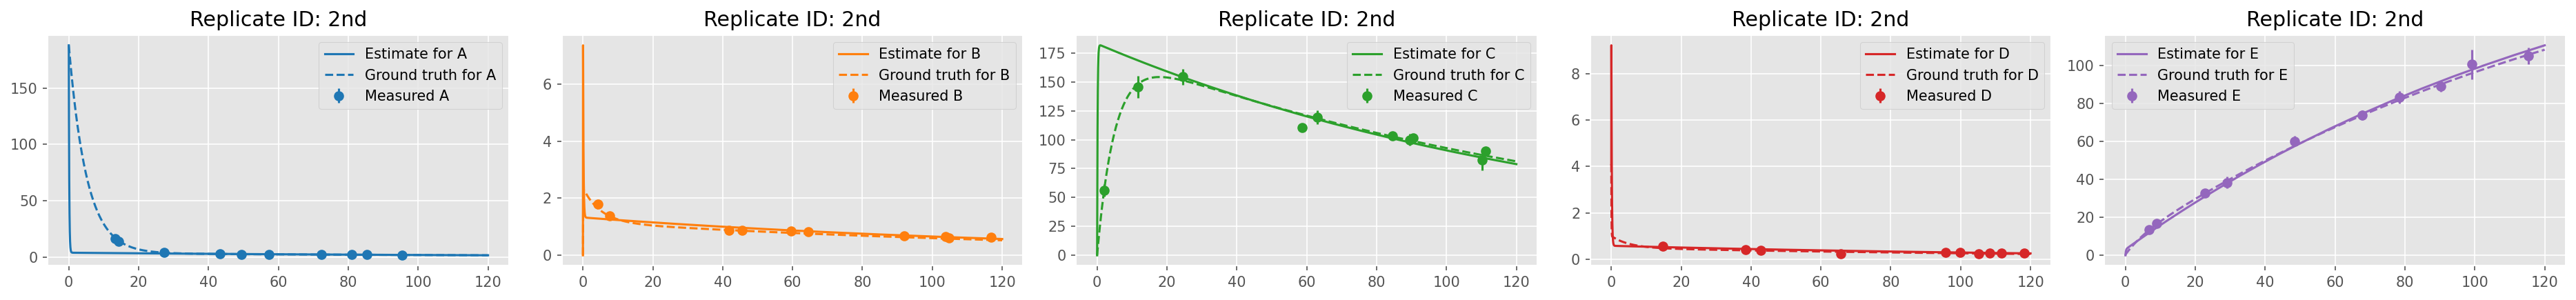

In [20]:
_ = Visualization.compare_estimates(
    parameters=estimates, 
    measurements=data, 
    caretaker=caretaker, 
    truth=simulation, 
    ncols=5,
)

In [21]:
estimates, est_info = caretaker.estimate_parallel_continued(
    estimation_result=est_info,
    evolutions=15, # Run another 15 evolutions
    report_level=2, # Reduce verbosity
)

Running additional 15 evolutions for all 12 islands of the archipelago...

-------------Finished evolution 6-------------
Current best loss: 1412.7988950098022
-------------Finished evolution 7-------------
Current best loss: 1407.2374063124396
-------------Finished evolution 8-------------
Current best loss: 1373.6479655046514
-------------Finished evolution 9-------------
Current best loss: 1353.335631865767
-------------Finished evolution 10-------------
Current best loss: 1342.9004725947725
-------------Finished evolution 11-------------
Current best loss: 1342.9004725947725
-------------Finished evolution 12-------------
Current best loss: 1334.658235993093
-------------Finished evolution 13-------------
Current best loss: 1330.5590298020686
-------------Finished evolution 14-------------
Current best loss: 1329.5186345828029
-------------Finished evolution 15-------------
Current best loss: 1325.2570099019845
-------------Finished evolution 16-------------
Current best loss: 1324

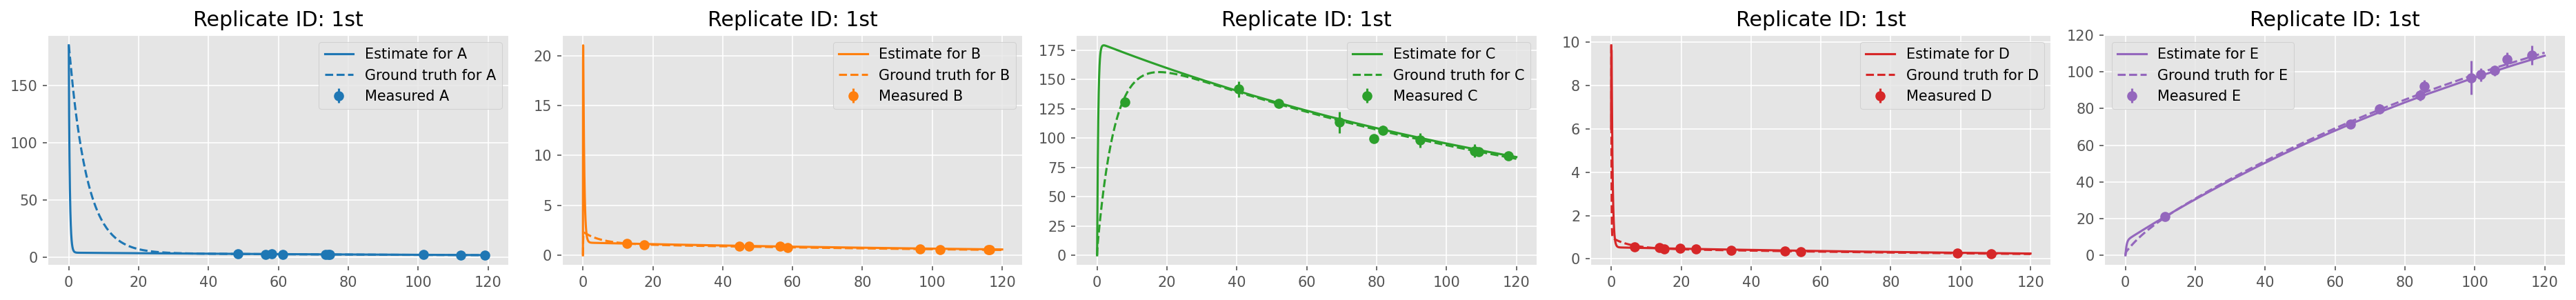

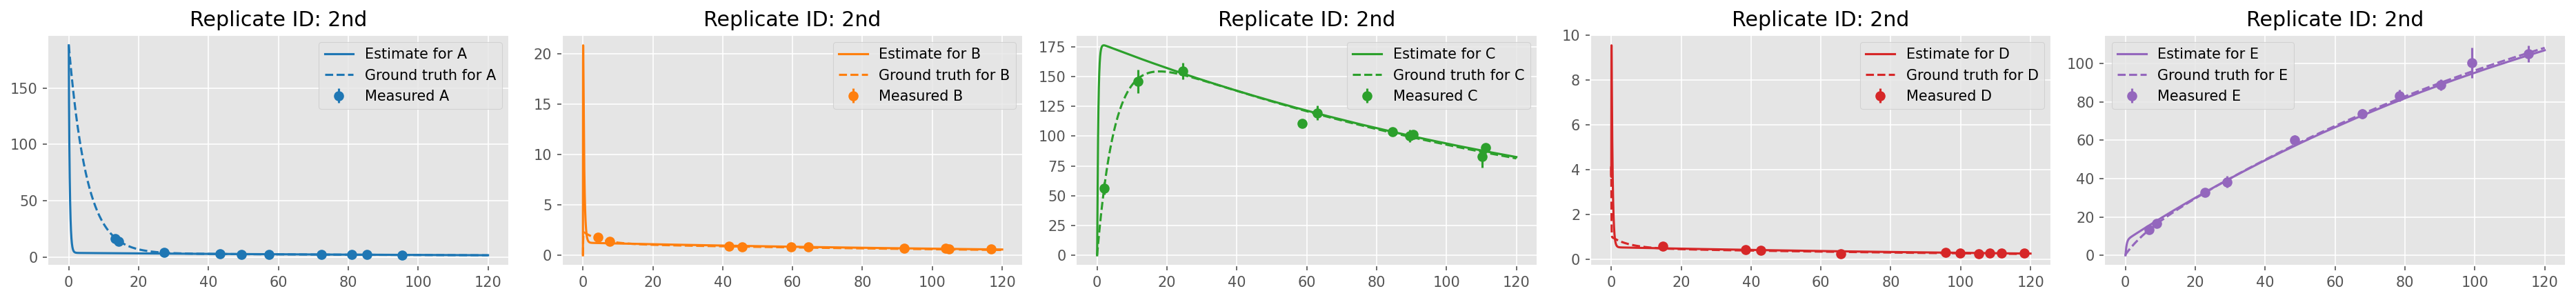

In [22]:
_ = Visualization.compare_estimates(
    parameters=estimates, 
    measurements=data, 
    caretaker=caretaker, 
    truth=simulation, 
    ncols=5,
)

In [23]:
estimates, est_info = caretaker.estimate_parallel_continued(
    estimation_result=est_info,
    evolutions=230,
    report_level=1, # Reduce verbosity
)

Running additional 230 evolutions for all 12 islands of the archipelago...

..................................................................................................
Reached a stopping criterion after evolution 118:
convergence: True
max_runtime: False
max_evotime: False
max_memory_share: False

Estimated parameters:
kAB: 0.20354833157787824
kAD: 1.3308801475817438e-06
kBC: 13.484089815343307
kBD: 2.117062148108042
kCB: 0.10022916628597692
kDA: 1.5795500640356526
kDB: 0.6681136598917543
kDC: 0.751798083104975
kDE: 2.4715085551882536

-------------Finished evolution 118-------------
Current best loss: 58.418187083572676
Average loss among the islands: 58.418203 +/- 0.000025 (0.000043 %)

Total runtime was 30.97 min



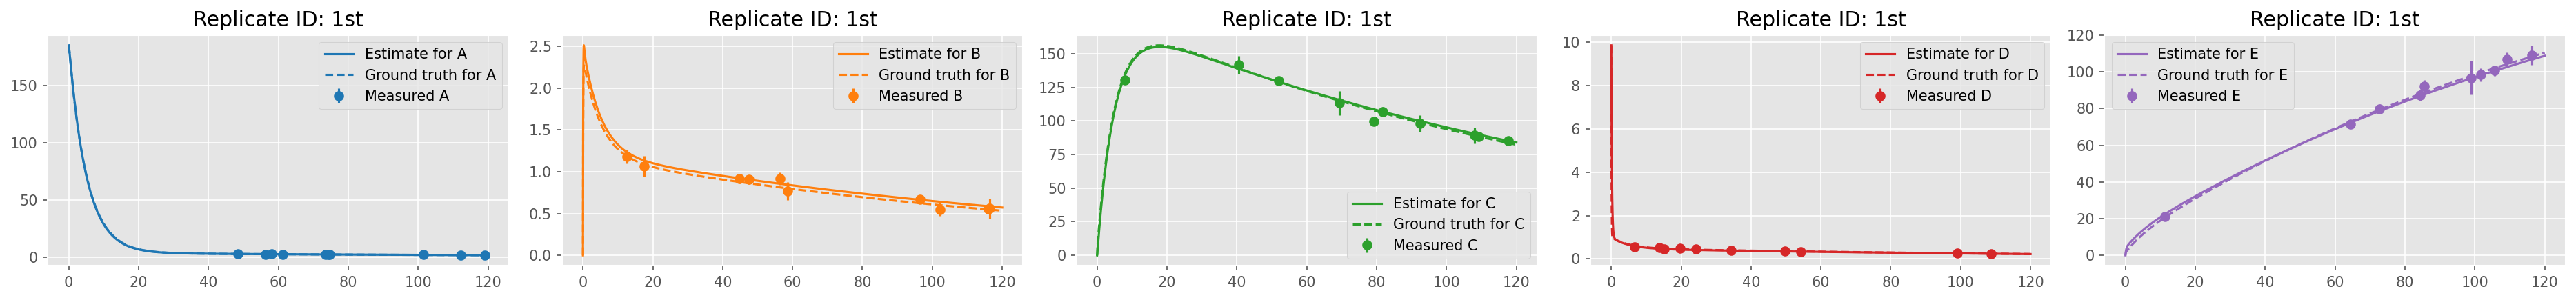

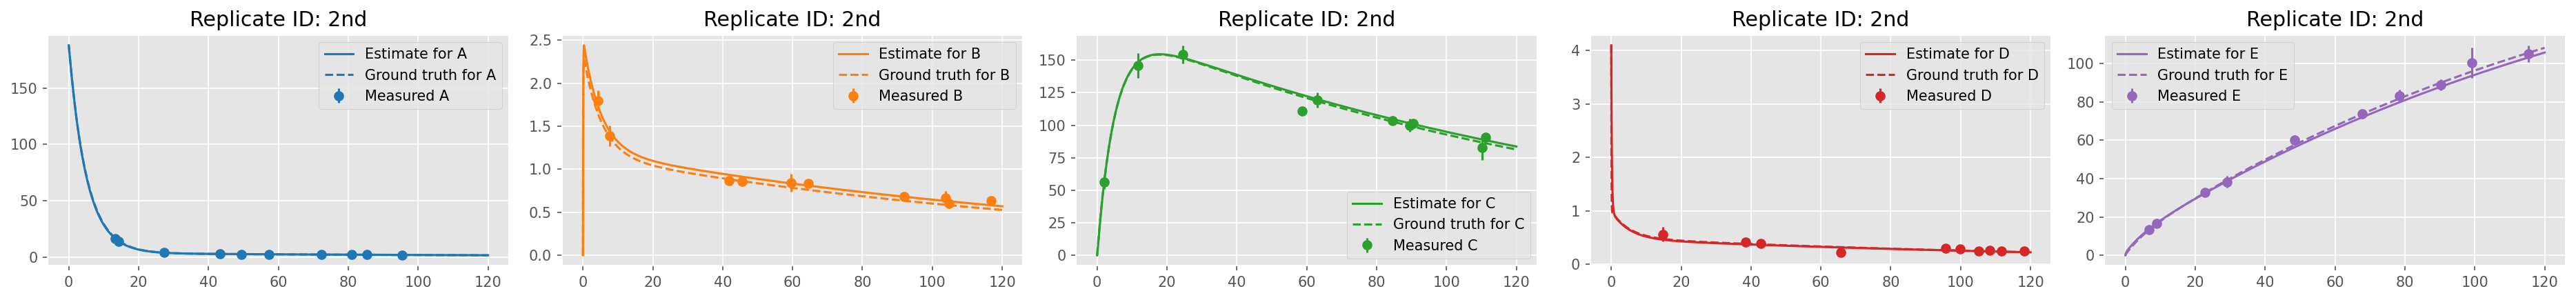

In [24]:
_ = Visualization.compare_estimates(
    parameters=estimates, 
    measurements=data, 
    caretaker=caretaker, 
    truth=simulation, 
    ncols=5,
)

In [25]:
uncerts = caretaker.get_parameter_uncertainties(estimates, measurements=data, report_level=1)


Estimated parameters:
----------
kAB: 2.04e-01 +/- 4.17e-03 (2.05 %)
kAD: 1.33e-06 +/- 3.29e-03 (247392.48 %)
kBC: 1.35e+01 +/- 2.44e+00 (18.11 %)
kBD: 2.12e+00 +/- 5.89e-01 (27.82 %)
kCB: 1.00e-01 +/- 9.20e-03 (9.18 %)
kDA: 1.58e+00 +/- 5.03e-02 (3.19 %)
kDB: 6.68e-01 +/- 5.97e+00 (893.63 %)
kDC: 7.52e-01 +/- 5.29e+00 (704.22 %)
kDE: 2.47e+00 +/- 6.18e-02 (2.50 %)


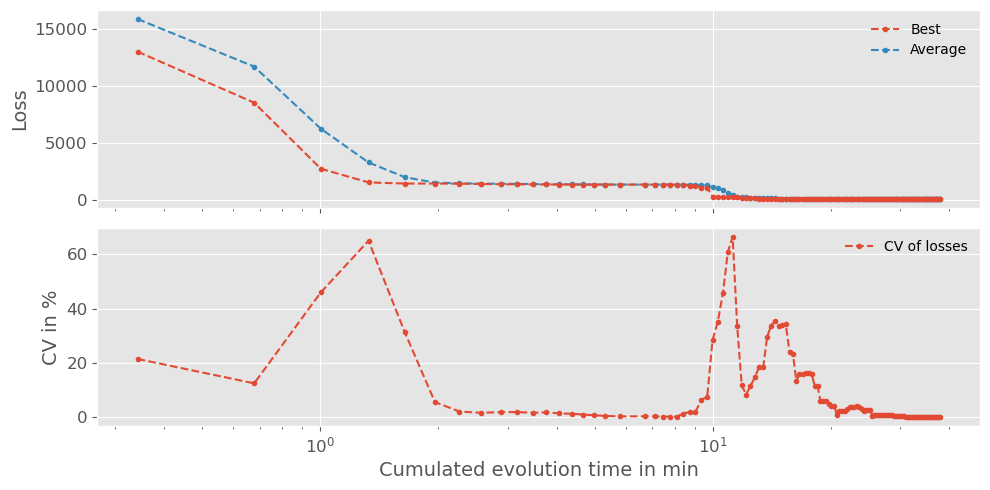

In [26]:
_ = est_info.plot_loss_trail()

<ipython-input-27-0b2493e8e4ec>:4: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_yscale('log', basey=2)


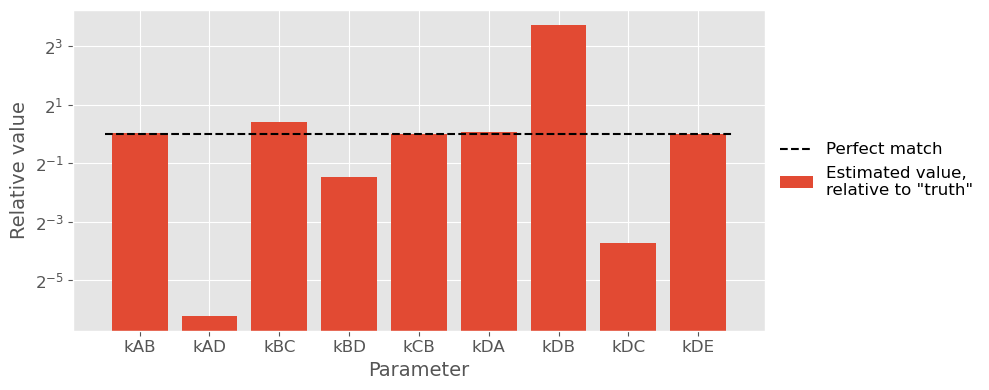

In [27]:
fig, ax = pyplot.subplots(dpi=100, figsize=(10, 4))
rel_estimates = {_p : estimates[_p]/_pars_for_comp[_p] for _p in estimates}
ax.bar(rel_estimates.keys(), rel_estimates.values(), label='Estimated value,\nrelative to "truth"')
ax.set_yscale('log', basey=2)
_x = numpy.arange(len(unknowns))
_x = [_x[0]-0.5, *_x, _x[-1]+0.5]
ax.plot(_x, [1]*len(_x), linestyle='--', zorder=2, color='black', label='Perfect match')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12, frameon=False)
ax.set_xlabel('Parameter', size=14)
ax.set_ylabel('Relative value', size=14)
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
fig.tight_layout()